# Predicitive maintanance model

Made by: Joey Einerhand, CÃ©dric Cortenraede, Lennox Narinx, Giuseppe Collura

## Get file
All files from the data directory will be loaded, _*this can take some time_\
based on the loaded data a dataframe will be created

In [1]:
import pandas as pd
import os

# Update "data_dir" location if necessary
data_dir = "data"
files = os.listdir(data_dir)
files = [file for file in files if file != "documentation.txt" and file != 'description.txt' and file != 'profile.txt']

In [2]:
df = pd.DataFrame()

# Load the sensor data
# Takes the mean of each row to illuminate different frequencies
for i in range(len(files)):
    df[files[i].strip(".txt")] = pd.read_csv(os.path.join(data_dir, files[i]), sep="\t", header=None, names=[files[i]]).mean(axis=1).to_numpy()

# Load the profiles
profiles = ["Cooler condition", "Valve condition", "Internal pump leakage", "Hydraulic accumulator", "Stable flag"]
for i in range(len(profiles)):
    df[profiles[i]] = pd.read_csv(os.path.join(data_dir,'profile.txt'), sep="\t", header=None)[i].to_numpy()

df

,CE,CP,EPS1,FS1,FS2,PS1,PS2,PS3,PS4,PS5,...,TS1,TS2,TS3,TS4,VS1,Cooler condition,Valve condition,Internal pump leakage,Hydraulic accumulator,Stable flag
0,28.866,1.383,2409.6,8.036,10.373,151.19,125.10,2.211,0.000,9.722,...,36.152,41.250,38.594,33.555,0.543,3,100,0,130,1
1,23.588,1.164,2397.8,7.890,10.391,150.86,125.04,2.219,0.000,9.623,...,37.477,42.105,39.250,35.121,0.534,3,100,0,130,1
2,21.519,1.103,2383.8,7.952,10.356,150.62,124.88,2.266,0.000,9.521,...,38.621,43.035,40.043,36.121,0.534,3,100,0,130,1
3,20.403,1.091,2372.0,7.773,10.261,150.28,124.59,2.273,0.000,9.420,...,39.461,43.988,40.922,36.988,0.542,3,100,0,130,1
4,20.016,1.106,2369.6,7.825,10.216,150.19,124.51,2.297,0.000,9.333,...,40.391,44.871,41.758,37.754,0.537,3,100,0,130,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,46.382,2.142,2415.6,7.874,10.171,151.86,125.73,2.273,10.207,9.979,...,35.414,40.922,38.187,30.379,0.527,100,100,0,90,0
2201,46.729,2.134,2413.6,7.787,10.174,151.78,125.44,2.406,10.193,9.953,...,35.398,40.891,38.195,30.375,0.544,100,100,0,90,0
2202,46.502,2.144,2413.6,7.685,10.171,151.83,125.94,2.250,10.246,9.998,...,35.437,40.898,38.160,30.379,0.517,100,100,0,90,0
2203,46.570,2.148,2415.6,7.793,10.189,151.78,125.91,2.281,10.189,9.953,...,35.441,40.898,38.176,30.375,0.528,100,100,0,90,0


## Analyse data
- The analysis looks at the correlation of the different columns in comparison to each other\
- This gives a filter to use later\
- The filter will be used to determine the columns impacting for the result

In [3]:
import seaborn as sb
import matplotlib.pyplot as plt
import math

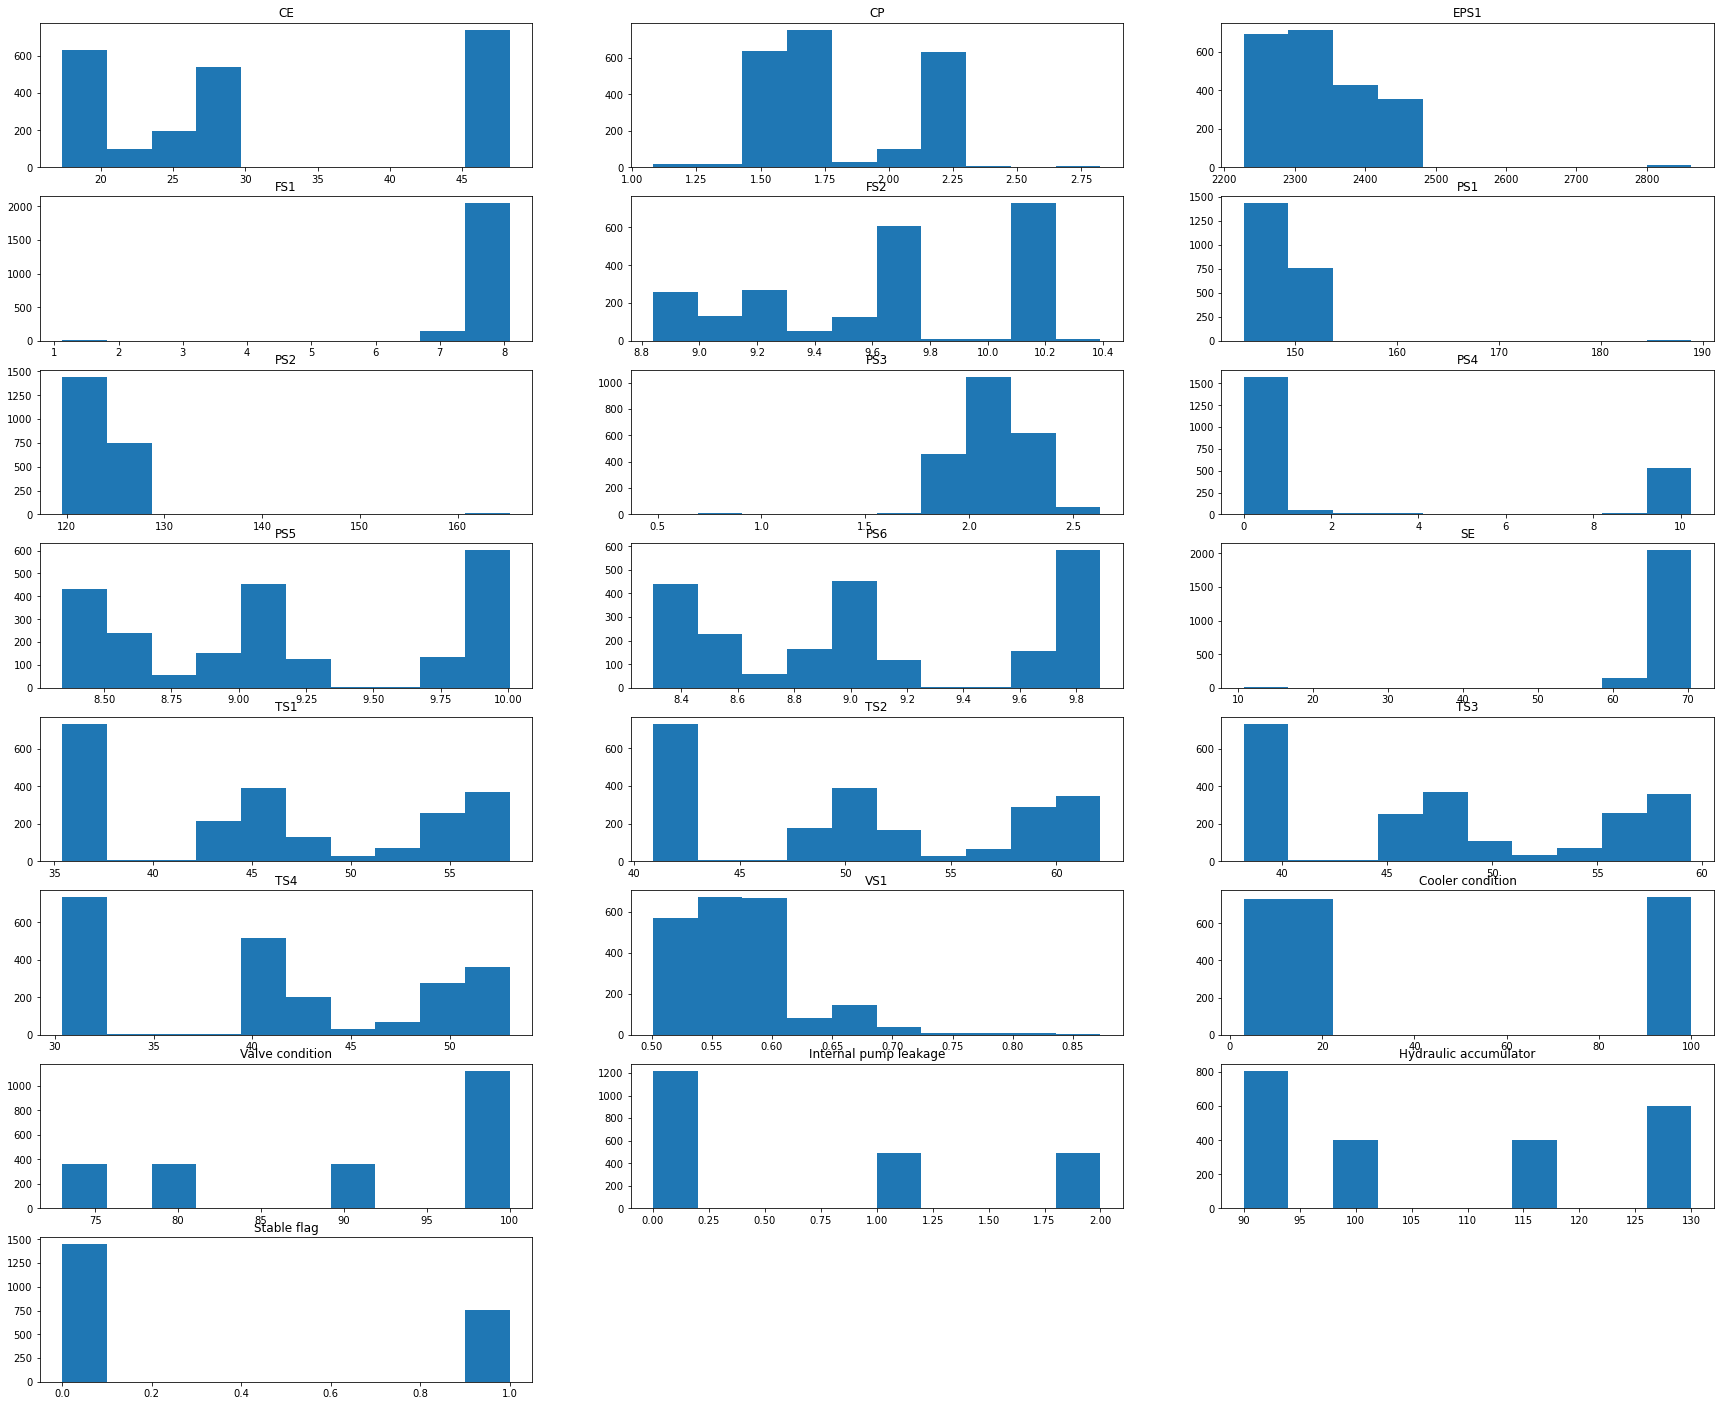

In [4]:
plt.figure(figsize=(30, 25))

i = 1
for column in df:
    data = df[column]
    plt.subplot(math.ceil(len(df.columns) / 3), 3, i)
    
    plt.title(column)
    plt.hist(data)
    
    i += 1

plt.show()

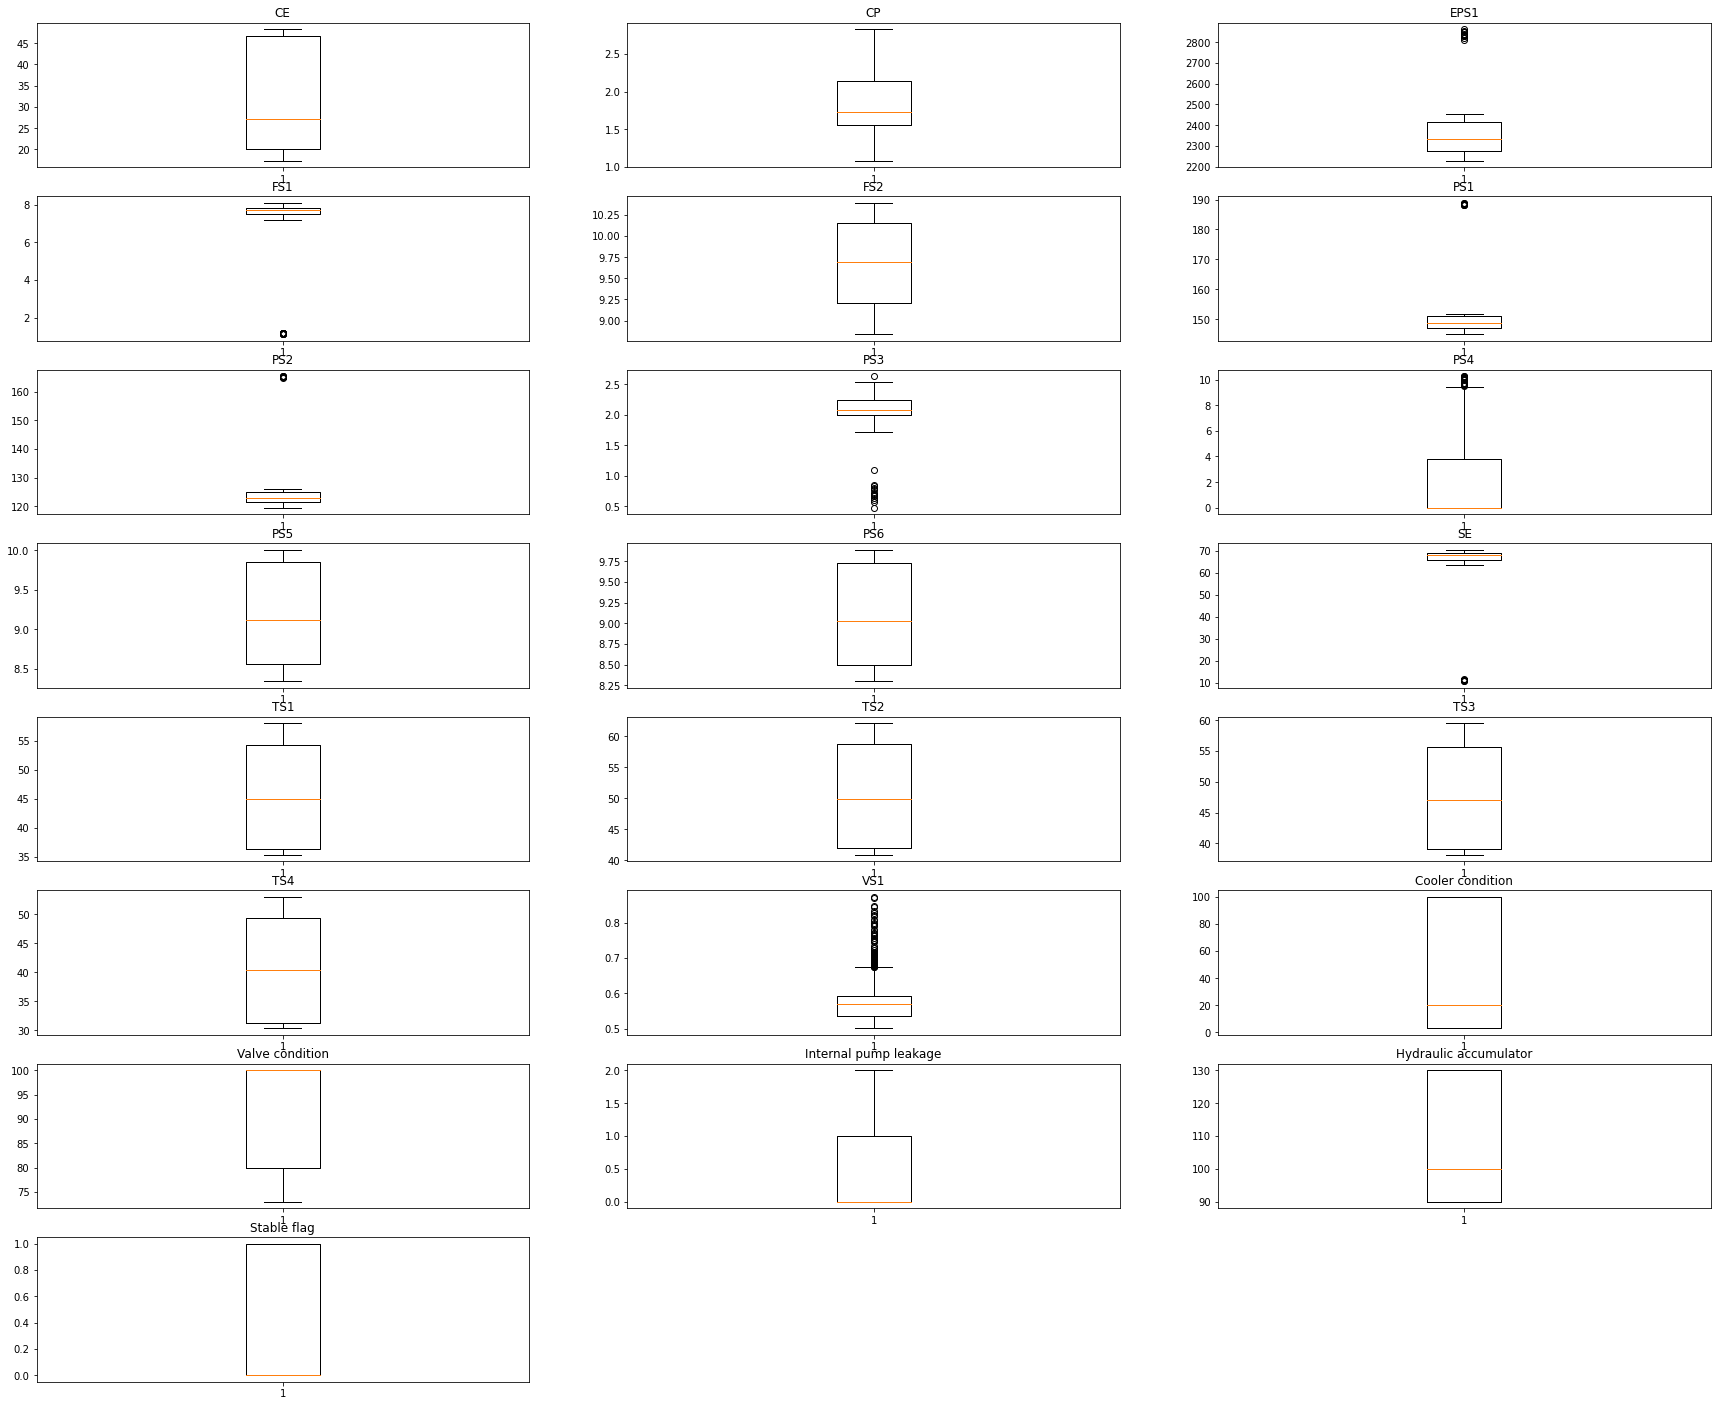

In [5]:
plt.figure(figsize=(30, 25))

i = 1
for column in df:
    data = df[column]
    plt.subplot(math.ceil(len(df.columns) / 3), 3, i)
    
    plt.title(column)
    plt.boxplot(data)
    
    i += 1

plt.show()

<AxesSubplot:>

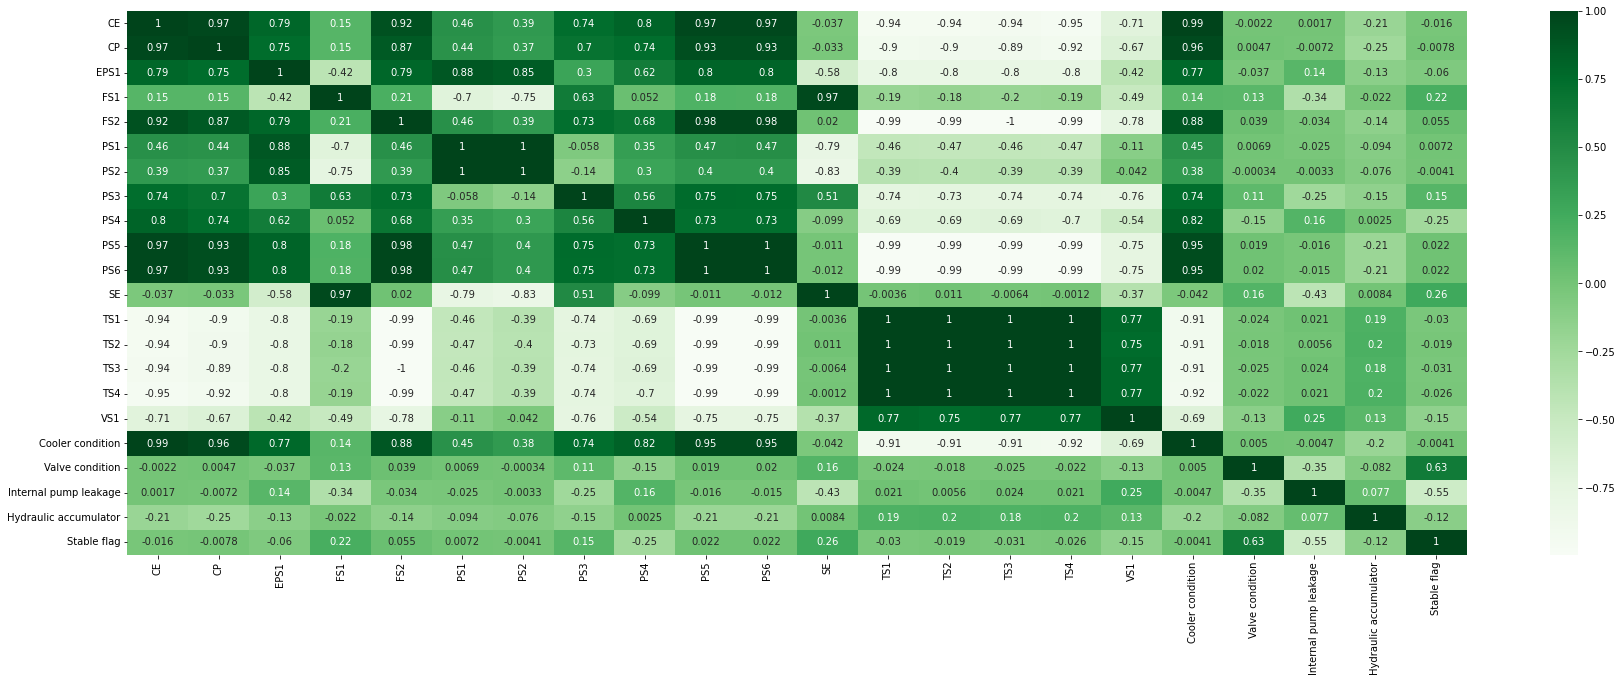

In [6]:
corr = df.corr()
plt.figure(figsize=(30, 10))
sb.heatmap(corr, cmap="Greens", annot=True)

## Making model
## Predicting LSTM
_Long Short Term Memory_

,Cooler condition,TS1,EPS1,FS2,PS3,PS4,PS5,VS1
2200,100,35.414,2415.6,10.171,2.273,10.207,9.979,0.527
2201,100,35.398,2413.6,10.174,2.406,10.193,9.953,0.544
2202,100,35.437,2413.6,10.171,2.250,10.246,9.998,0.517
2203,100,35.441,2415.6,10.189,2.281,10.189,9.953,0.528
2204,100,35.426,2417.0,10.176,2.250,10.212,9.964,0.531


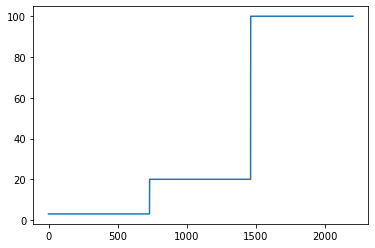

In [39]:
import matplotlib.pyplot as plt
import datetime
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import metrics

plt.plot(df["Cooler condition"], label="Cooler condition plot")

data = pd.DataFrame(index=range(0, len(df["Cooler condition"])), columns=["Cooler condition","TS1", "EPS1", "FS2", "PS3", "PS4", "PS5", "VS1"])
for i in range(0, len(data)):
    data["Cooler condition"][i] = df["Cooler condition"][i]
    data["TS1"][i] = df["TS1"][i]
    data["EPS1"][i] = df["EPS1"][i]
    data["FS2"][i] = df["FS2"][i]
    data["PS3"][i] = df["PS3"][i]
    data["PS4"][i] = df["PS4"][i]
    data["PS5"][i] = df["PS5"][i]
    data["VS1"][i] = df["VS1"][i]

#data["Time"] = data["Time"].astype(int)
data["Cooler condition"] = data["Cooler condition"].astype(int)
data["TS1"] = data["TS1"].astype(float)
data["EPS1"] = data["EPS1"].astype(float)
data["FS2"] = data["FS2"].astype(float)
data["PS3"] = data["PS3"].astype(float)
data["PS4"] = data["PS4"].astype(float)
data["PS5"] = data["PS5"].astype(float)
data["VS1"] = data["VS1"].astype(float)

data.head()

In [40]:
X_scaler=MinMaxScaler(feature_range=(0,1))
Y_scaler=MinMaxScaler(feature_range=(0,1))

X_data = X_scaler.fit_transform(data[["TS1", "EPS1", "FS2", "PS3", "PS4", "PS5", "VS1"]])
Y_data = Y_scaler.fit_transform(data[["Cooler condition"]])

# split into train and test sets
# Train is the dataset which the model is trained on
# Test is the dataset which the model is verified with

trainX, testX, trainY, testY = train_test_split(X_data, Y_data, test_size=0.1, random_state=None, shuffle=False)

print(len(trainX), len(testX))

1984 221


In [41]:
# reshape into X=t and Y=t+1
look_back = 1
# trainX, trainY = create_dataset(train, look_back)
# testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [55]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(7, input_shape=(look_back, 7)))
#model.add(LSTM(4, return_sequences=True,stateful=True, batch_input_shape=(1, None,  look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, verbose=1)

Epoch 1/50
1984/1984 [==============================] - 1s 492us/step - loss: 0.1382
Epoch 2/50
1984/1984 [==============================] - 0s 111us/step - loss: 0.0613
Epoch 3/50
1984/1984 [==============================] - 0s 118us/step - loss: 0.0283
Epoch 4/50
1984/1984 [==============================] - 0s 109us/step - loss: 0.0189
Epoch 5/50
1984/1984 [==============================] - 0s 103us/step - loss: 0.0163
Epoch 6/50
1984/1984 [==============================] - 0s 119us/step - loss: 0.0144
Epoch 7/50
1984/1984 [==============================] - 0s 111us/step - loss: 0.0128
Epoch 8/50
1984/1984 [==============================] - 0s 106us/step - loss: 0.0114
Epoch 9/50
1984/1984 [==============================] - 0s 106us/step - loss: 0.0102
Epoch 10/50
1984/1984 [==============================] - 0s 99us/step - loss: 0.0090
Epoch 11/50
1984/1984 [==============================] - 0s 108us/step - loss: 0.0080
Epoch 12/50
1984/1984 [==============================] - 0s 107u

In [56]:
#Try to predict a portion of the dataset with the trained model
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(X_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(X_data)
testPredictPlot[:, :] = np.nan
#testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
testPredictPlot[len(trainPredict):len(X_data), :] = testPredict



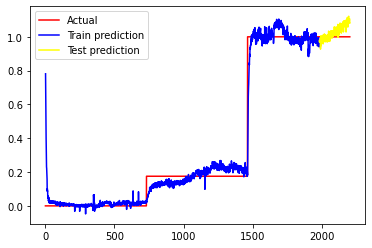

[[       nan        nan        nan ...        nan        nan        nan]
 [0.78126025 0.78126025 0.78126025 ... 0.78126025 0.78126025 0.78126025]
 [0.66516715 0.66516715 0.66516715 ... 0.66516715 0.66516715 0.66516715]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]


In [57]:
# ---------------------------------------
#  Convert data to something we can plot
# ---------------------------------------


# plot baseline and predictions
# plt.plot(X_data, color="red")
# plt.plot(newTrainPredictPlot, color="blue")
# plt.plot(newTestPredictPlot, color="yellow")
plt.plot(Y_data, color="red", label="Actual")
plt.plot(trainPredictPlot[:,0], color="blue", label='Train prediction')
plt.plot(testPredictPlot[:,0], color="yellow", label='Test prediction')

plt.legend()
plt.show()
print(trainPredictPlot)

In [58]:
## ----------------------------
## METRICS
## ----------------------------
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n') 
    
print("Training metrics")
timeseries_evaluation_metrics_func(trainY, trainPredict)
print("Testing metrics")
timeseries_evaluation_metrics_func(testY, testPredict)

# trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))

Training metrics
Evaluation metric results:-
MSE is : 0.0034449428093392192
MAE is : 0.033066433204302643
RMSE is : 0.0586936351688939
MAPE is : inf
R2 is : 0.9793292897860144

Testing metrics
Evaluation metric results:-
MSE is : 0.0025220446312851047
MAE is : 0.03907433462358713
RMSE is : 0.05021996247793406
MAPE is : 3.907433462358713
R2 is : 0.0



ipykernel_launcher:7: RuntimeWarning: divide by zero encountered in true_divide
